# Problem 4.3

**Integrated Energy Grids**

**Problem 4.3**

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install numpy networkx pandas matplotlib
```
:::

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

We start by creating the network and adding the nodes and links.

In [2]:
N = nx.Graph()
N.add_nodes_from([0, 1, 2, 3, 4])
N.add_edges_from([(0, 1), (1, 2), (1, 3), (1, 4), (2,4)])

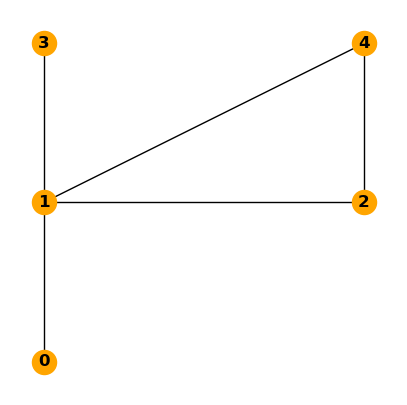

In [3]:
pos=nx.get_node_attributes(N,'pos')
pos[0] = np.array([0, 0])
pos[1] = np.array([0, 1])
pos[2] = np.array([1, 1])
pos[3] = np.array([0, 2])
pos[4] = np.array([1, 2])

fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(N, with_labels=True, ax=ax, pos=pos, node_color="orange", font_weight="bold")

**c) Calculate the Degree, Adjacency, Incidence, and Laplacian matrix**

Adjacency matrix (Careful, `networkx` will yield a weighted adjacency matrix by default!)

In [4]:
A = nx.adjacency_matrix(N, weight=None).todense()

We can plot the matrix to get a visual overview of how interconnected is the network

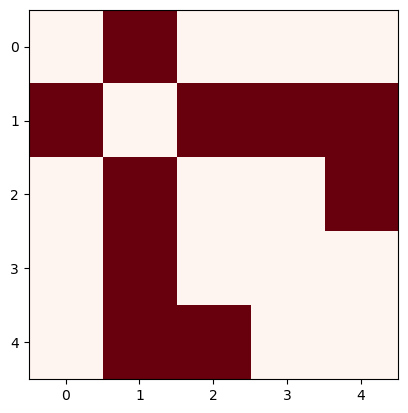

In [5]:
plt.imshow(A, cmap="Reds")

incidence matrix (Careful, `networkx` will yield a incidence matrix without orientation by default!)

In [6]:
K=nx.incidence_matrix(N, oriented=True).todense()
K

array([[-1.,  0.,  0.,  0.,  0.],
       [ 1., -1., -1., -1.,  0.],
       [ 0.,  1.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.]])

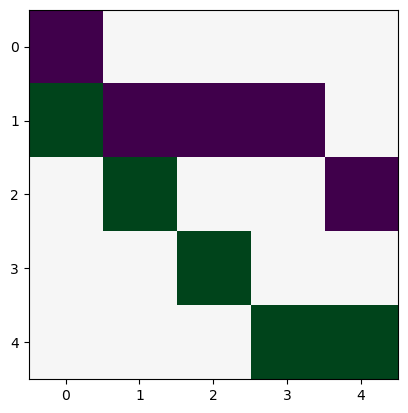

In [7]:
plt.imshow(K, cmap="PRGn")

Laplacian matrix (Careful, `networkx` will yield a weighted adjacency matrix by default!)

In [8]:
L = nx.laplacian_matrix(N, weight=None).todense()
L

array([[ 1, -1,  0,  0,  0],
       [-1,  4, -1, -1, -1],
       [ 0, -1,  2,  0, -1],
       [ 0, -1,  0,  1,  0],
       [ 0, -1, -1,  0,  2]])

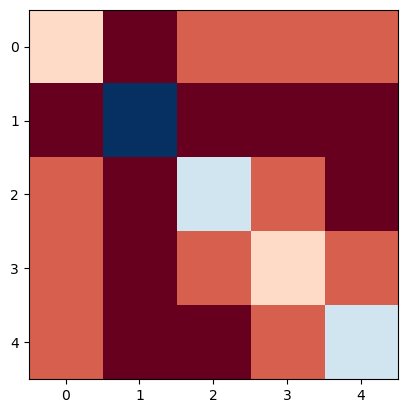

In [9]:
plt.imshow(L, cmap="RdBu")

**a) Assuming that the reactance in the links is $x_l$=1, calculate the Power Transfer Distribution Factor (PTDF) matrix**

The **PTDF** matrix measures the sensitivity of power flows in each transmission line relative to incremental changes in nodal power injections or withdrawals throughout the electricity network. 

$$p_\ell = \frac{1}{x_\ell}\sum_{i,j} K_{i\ell}  (L^{-1})_{ij} p_j$$
$$p_\ell = \sum_j \text{PTDF}_{\ell j} p_j$$

The weighted Laplacian of the network is not invertible, but we can use the [Moore Penrose pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)

In [10]:
L_inv = np.linalg.pinv(L)

or apply a trick by disregarding the first column and row of the weighted Laplacian for inversion:

In [11]:
n_nodes = L.shape[0]

L_inv = np.linalg.inv(L[1:, 1:])
L_inv = np.hstack((np.zeros((n_nodes - 1, 1)), L_inv))
L_inv = np.vstack((np.zeros(n_nodes), L_inv))

Now, we can calculate the PTDF matrix

In [12]:
PTDF = K.T.dot(L_inv)

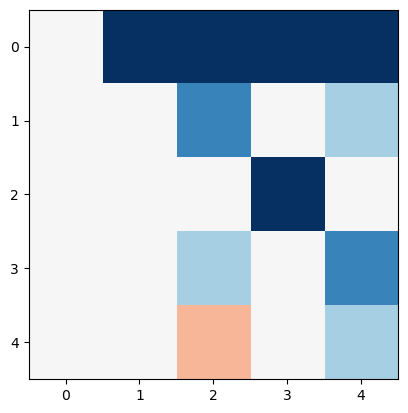

In [13]:
plt.imshow(PTDF, cmap="RdBu", vmin=-1, vmax=1)

**b) Assuming the power injection pattern described in Problem 4.1 determine the power flows in the lines of the network and plot them.**

In [14]:
p_i =[-2, 5, 6, -8, -1]
p_l = PTDF.dot(p_i)
p_l

array([ 2.        ,  3.66666667, -8.        ,  1.33333333, -2.33333333])

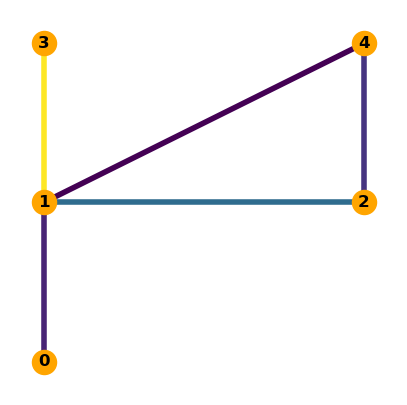

In [15]:
abs_p_l = np.abs(p_l)
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(N, 
        with_labels=True, 
        ax=ax, 
        pos=pos, 
        node_color="orange", 
        font_weight="bold",  
        edge_color=abs_p_l, 
        width=4)

**c) Assume now that the links unitary susceptance is $x_{l}$=[1, 0.5, 0.5, 0.5, 1], calculate the weighted Laplacian (or susceptance matrix),  the PTDF matrix, the power flows and plot them.**

If we want to calculate the weighted Laplacian $L = KBK^\top$, we also need the diagonal matrix $B$ for the susceptances (i.e inverse of reactances; $1/x_\ell$):

In [16]:
x_pu = [1, 0.5, 0.5, 0.5, 1]
b = [1 / x for x in x_pu]

B = np.diag(b)

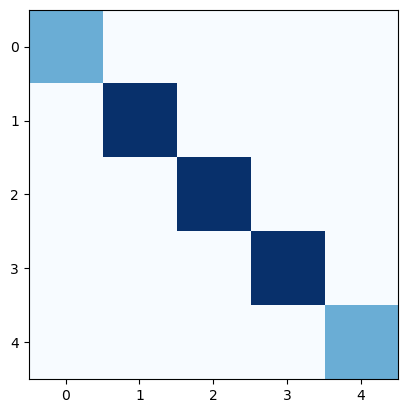

In [17]:
plt.imshow(B, cmap="Blues") 

Now, we can calculate the weighted Laplacian as $K_{il}\frac{1}{x_l}K_{lj}$

In [18]:
L = K.dot(B.dot(K.T))
L

array([[ 1., -1.,  0.,  0.,  0.],
       [-1.,  7., -2., -2., -2.],
       [ 0., -2.,  3.,  0., -1.],
       [ 0., -2.,  0.,  2.,  0.],
       [ 0., -2., -1.,  0.,  3.]])

We can invert the Laplacian and multiply by the transpose of the incidence matrix to create the PTDF matrix. 

In [19]:
L_inv = np.linalg.pinv(L)

In [20]:
PTDF = (B.dot(K.T)).dot(L_inv)

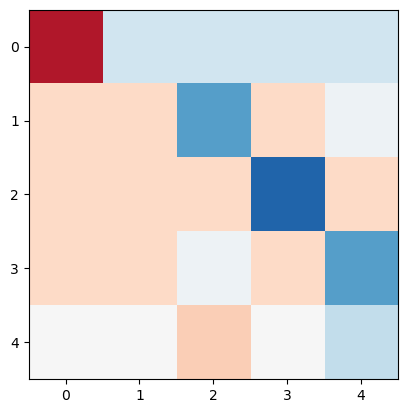

In [21]:
plt.imshow(PTDF, cmap="RdBu", vmin=-1, vmax=1)

And calculate the flows thrgoughout the lines

In [22]:
p_l=PTDF.dot(p_i)
p_l

array([ 2.  ,  4.25, -8.  ,  0.75, -1.75])